Домашнее задание по теме «Регуляризация. Гребневая регрессия. Лассо регрессия»

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

Загружаем данные

In [50]:
train_df=pd.read_csv('train.csv', index_col='id')

In [35]:
pd.options.display.float_format = '{:,.2f}'.format
train_df.head()

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
id,,,,,,,,,,,,,,,,,,,,
0,19.00,Female,"10,049.00",Married,1.00,Bachelor's,Self-Employed,22.60,Urban,Premium,2.00,17.00,372.00,5.00,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,"2,869.00"
1,39.00,Female,"31,678.00",Divorced,3.00,Master's,NaN,15.57,Rural,Comprehensive,1.00,12.00,694.00,2.00,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,"1,483.00"
2,23.00,Male,"25,602.00",Divorced,3.00,High School,Self-Employed,47.18,Suburban,Premium,1.00,14.00,NaN,3.00,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.00
3,21.00,Male,"141,855.00",Married,2.00,Bachelor's,NaN,10.94,Rural,Basic,1.00,0.00,367.00,1.00,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.00
4,21.00,Male,"39,651.00",Single,1.00,Bachelor's,Self-Employed,20.38,Rural,Premium,0.00,8.00,598.00,4.00,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,"2,022.00"


In [ ]:
train_df.info(memory_usage=True) 

<class 'pandas.core.frame.DataFrame'>
Index: 1200000 entries, 0 to 1199999
Data columns (total 20 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Age                   1181295 non-null  float64
 1   Gender                1200000 non-null  object 
 2   Annual Income         1155051 non-null  float64
 3   Marital Status        1181471 non-null  object 
 4   Number of Dependents  1090328 non-null  float64
 5   Education Level       1200000 non-null  object 
 6   Occupation            841925 non-null   object 
 7   Health Score          1125924 non-null  float64
 8   Location              1200000 non-null  object 
 9   Policy Type           1200000 non-null  object 
 10  Previous Claims       835971 non-null   float64
 11  Vehicle Age           1199994 non-null  float64
 12  Credit Score          1062118 non-null  float64
 13  Insurance Duration    1199999 non-null  float64
 14  Policy Start Date     1200000 non-null 

Можно заметить, что в таблице есть пропуски. Оставим их для EDA, а для обучения модели заполним их.

In [37]:
#Подсчитываем сколько процентов незаполнено столбце
percent_missing = train_df.isnull().sum() * 100 / len(train_df.index)
missing_value_df = pd.DataFrame({'Незаполнено столбце %': percent_missing})

missing_value_df

,Незаполнено столбце %
Age,1.56
Gender,0.00
Annual Income,3.75
Marital Status,1.54
Number of Dependents,9.14
Education Level,0.00
Occupation,29.84
Health Score,6.17
Location,0.00
Policy Type,0.00


В Policy Start Date записано год, месяц, день и даже время. Так как это категориальная переменная её придется закодировать. Чтобы уменьшить кол-во данных для кодировки заменим этот столбец на Policy Start Year. В нем будет храниться только год из даты.

In [51]:
train_df['Policy Start Year'] = pd.DatetimeIndex(train_df['Policy Start Date']).year
train_df

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,...,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,Policy Start Year
id,,,,,,,,,,,,,,,,,,,,,
0,19.00,Female,"10,049.00",Married,1.00,Bachelor's,Self-Employed,22.60,Urban,Premium,...,17.00,372.00,5.00,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,"2,869.00",2023
1,39.00,Female,"31,678.00",Divorced,3.00,Master's,NaN,15.57,Rural,Comprehensive,...,12.00,694.00,2.00,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,"1,483.00",2023
2,23.00,Male,"25,602.00",Divorced,3.00,High School,Self-Employed,47.18,Suburban,Premium,...,14.00,NaN,3.00,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.00,2023
3,21.00,Male,"141,855.00",Married,2.00,Bachelor's,NaN,10.94,Rural,Basic,...,0.00,367.00,1.00,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.00,2024
4,21.00,Male,"39,651.00",Single,1.00,Bachelor's,Self-Employed,20.38,Rural,Premium,...,8.00,598.00,4.00,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,"2,022.00",2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,36.00,Female,"27,316.00",Married,0.00,Master's,Unemployed,13.77,Urban,Premium,...,5.00,372.00,3.00,2023-05-03 15:21:39.257696,Poor,No,Daily,Apartment,"1,303.00",2023
1199996,54.00,Male,"35,786.00",Divorced,NaN,Master's,Self-Employed,11.48,Rural,Comprehensive,...,10.00,597.00,4.00,2022-09-10 15:21:39.134960,Poor,No,Weekly,Apartment,821.00,2022
1199997,19.00,Male,"51,884.00",Divorced,0.00,Master's,NaN,14.72,Suburban,Basic,...,19.00,NaN,6.00,2021-05-25 15:21:39.106582,Good,No,Monthly,Condo,371.00,2021


In [52]:
train_df = train_df.drop('Policy Start Date', axis=1)
train_df.head()

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,Policy Start Year
id,,,,,,,,,,,,,,,,,,,,
0,19.00,Female,"10,049.00",Married,1.00,Bachelor's,Self-Employed,22.60,Urban,Premium,2.00,17.00,372.00,5.00,Poor,No,Weekly,House,"2,869.00",2023
1,39.00,Female,"31,678.00",Divorced,3.00,Master's,NaN,15.57,Rural,Comprehensive,1.00,12.00,694.00,2.00,Average,Yes,Monthly,House,"1,483.00",2023
2,23.00,Male,"25,602.00",Divorced,3.00,High School,Self-Employed,47.18,Suburban,Premium,1.00,14.00,NaN,3.00,Good,Yes,Weekly,House,567.00,2023
3,21.00,Male,"141,855.00",Married,2.00,Bachelor's,NaN,10.94,Rural,Basic,1.00,0.00,367.00,1.00,Poor,Yes,Daily,Apartment,765.00,2024
4,21.00,Male,"39,651.00",Single,1.00,Bachelor's,Self-Employed,20.38,Rural,Premium,0.00,8.00,598.00,4.00,Poor,Yes,Weekly,House,"2,022.00",2021


Выделяем категориальные и числовые столбцы и создаем подтаблицы для EDA.

In [53]:
category_col = train_df.select_dtypes(include=['object']).columns.tolist()
category_col.append('Policy Start Year')
category_col

['Gender',
 'Marital Status',
 'Education Level',
 'Occupation',
 'Location',
 'Policy Type',
 'Customer Feedback',
 'Smoking Status',
 'Exercise Frequency',
 'Property Type',
 'Policy Start Year']

In [54]:
train_df_cat = train_df[category_col]
number_col = train_df.select_dtypes(include=['number']).drop('Policy Start Year', axis=1).columns.tolist()
train_df_num = train_df[number_col]

Заполнение пропусков

In [64]:
train_df = train_df.apply(lambda x: x.fillna(x.mode()[0]))

In [65]:
#Подсчитываем сколько процентов незаполнено столбце
percent_missing = train_df.isnull().sum() * 100 / len(train_df.index)
missing_value_df = pd.DataFrame({'Незаполнено столбце %': percent_missing})

missing_value_df

,Незаполнено столбце %
Age,0.00
Gender,0.00
Annual Income,0.00
Marital Status,0.00
Number of Dependents,0.00
Education Level,0.00
Occupation,0.00
Health Score,0.00
Location,0.00
Policy Type,0.00


Для кодирования категориальных переменных будем использовать TargetOrdinalEncoding

In [66]:
def TargetOrdinalEncoding(df, col):
    ordinal_index = df.groupby([col])['Premium Amount'].mean().sort_values().index
    ordinal_label={k:i for i,k in enumerate(ordinal_index, 0)}
    df[f'{col}_ordinal_label']=df[col].map(ordinal_label)
    return df

In [67]:
for col in category_col:
    train_df = TargetOrdinalEncoding(train_df,col)
train_df

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,...,Marital Status_ordinal_label,Education Level_ordinal_label,Occupation_ordinal_label,Location_ordinal_label,Policy Type_ordinal_label,Customer Feedback_ordinal_label,Smoking Status_ordinal_label,Exercise Frequency_ordinal_label,Property Type_ordinal_label,Policy Start Year_ordinal_label
id,,,,,,,,,,,,,,,,,,,,,
0,19.00,Female,"10,049.00",Married,1.00,Bachelor's,Self-Employed,22.60,Urban,Premium,...,0,2,2,2,0,1,0,0,0,2
1,39.00,Female,"31,678.00",Divorced,3.00,Master's,Employed,15.57,Rural,Comprehensive,...,1,1,0,0,1,2,1,2,0,2
2,23.00,Male,"25,602.00",Divorced,3.00,High School,Self-Employed,47.18,Suburban,Premium,...,1,3,2,1,0,0,1,0,0,2
3,21.00,Male,"141,855.00",Married,2.00,Bachelor's,Employed,10.94,Rural,Basic,...,0,2,0,0,2,1,1,3,2,4
4,21.00,Male,"39,651.00",Single,1.00,Bachelor's,Self-Employed,20.38,Rural,Premium,...,2,2,2,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,36.00,Female,"27,316.00",Married,0.00,Master's,Unemployed,13.77,Urban,Premium,...,0,1,1,2,0,1,0,3,2,2
1199996,54.00,Male,"35,786.00",Divorced,3.00,Master's,Self-Employed,11.48,Rural,Comprehensive,...,1,1,2,0,1,1,0,0,2,0
1199997,19.00,Male,"51,884.00",Divorced,0.00,Master's,Employed,14.72,Suburban,Basic,...,1,1,0,1,2,0,0,2,1,1


In [68]:
train_df = train_df.drop(category_col, axis=1)
train_df

,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount,Gender_ordinal_label,Marital Status_ordinal_label,Education Level_ordinal_label,Occupation_ordinal_label,Location_ordinal_label,Policy Type_ordinal_label,Customer Feedback_ordinal_label,Smoking Status_ordinal_label,Exercise Frequency_ordinal_label,Property Type_ordinal_label,Policy Start Year_ordinal_label
id,,,,,,,,,,,,,,,,,,,,
0,19.00,"10,049.00",1.00,22.60,2.00,17.00,372.00,5.00,"2,869.00",0,0,2,2,2,0,1,0,0,0,2
1,39.00,"31,678.00",3.00,15.57,1.00,12.00,694.00,2.00,"1,483.00",0,1,1,0,0,1,2,1,2,0,2
2,23.00,"25,602.00",3.00,47.18,1.00,14.00,434.00,3.00,567.00,1,1,3,2,1,0,0,1,0,0,2
3,21.00,"141,855.00",2.00,10.94,1.00,0.00,367.00,1.00,765.00,1,0,2,0,0,2,1,1,3,2,4
4,21.00,"39,651.00",1.00,20.38,0.00,8.00,598.00,4.00,"2,022.00",1,2,2,2,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,36.00,"27,316.00",0.00,13.77,0.00,5.00,372.00,3.00,"1,303.00",0,0,1,1,2,0,1,0,3,2,2
1199996,54.00,"35,786.00",3.00,11.48,0.00,10.00,597.00,4.00,821.00,1,1,1,2,0,1,1,0,0,2,0
1199997,19.00,"51,884.00",0.00,14.72,0.00,19.00,434.00,6.00,371.00,1,1,1,0,1,2,0,0,2,1,1


In [69]:
train_df.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1200000 entries, 0 to 1199999
Data columns (total 20 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   Age                               1200000 non-null  float64
 1   Annual Income                     1200000 non-null  float64
 2   Number of Dependents              1200000 non-null  float64
 3   Health Score                      1200000 non-null  float64
 4   Previous Claims                   1200000 non-null  float64
 5   Vehicle Age                       1200000 non-null  float64
 6   Credit Score                      1200000 non-null  float64
 7   Insurance Duration                1200000 non-null  float64
 8   Premium Amount                    1200000 non-null  float64
 9   Gender_ordinal_label              1200000 non-null  int64  
 10  Marital Status_ordinal_label      1200000 non-null  int64  
 11  Education Level_ordinal_label     1200000 

Уменьшим вес таблицы с помощью изменения типа данных.

In [70]:
int_cols = train_df.select_dtypes('int').columns

float_cols = train_df.select_dtypes('float').columns
for col in int_cols:
    train_df[col] = pd.to_numeric(train_df[col], downcast='integer')
for col in float_cols:
    train_df[col] = pd.to_numeric(train_df[col], downcast='float')

In [71]:
train_df.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1200000 entries, 0 to 1199999
Data columns (total 20 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   Age                               1200000 non-null  float32
 1   Annual Income                     1200000 non-null  float32
 2   Number of Dependents              1200000 non-null  float32
 3   Health Score                      1200000 non-null  float32
 4   Previous Claims                   1200000 non-null  float32
 5   Vehicle Age                       1200000 non-null  float32
 6   Credit Score                      1200000 non-null  float32
 7   Insurance Duration                1200000 non-null  float32
 8   Premium Amount                    1200000 non-null  float32
 9   Gender_ordinal_label              1200000 non-null  int8   
 10  Marital Status_ordinal_label      1200000 non-null  int8   
 11  Education Level_ordinal_label     1200000 

# EDA

Для числовых столбцов:

In [72]:
#Подсчитываем сколько процентов незаполнено столбце
percent_missing = train_df_num.isnull().sum() * 100 / len(train_df_num.index)
missing_value_df = pd.DataFrame({'Незаполнено столбце %': percent_missing})

missing_value_df

,Незаполнено столбце %
Age,1.56
Annual Income,3.75
Number of Dependents,9.14
Health Score,6.17
Previous Claims,30.34
Vehicle Age,0.00
Credit Score,11.49
Insurance Duration,0.00
Premium Amount,0.00


In [73]:
#Находим максимальные и минимальные значения
min_max_df = pd.DataFrame({'Максимальное значение': train_df_num.max(), 'Минимальное значение': train_df_num.min()})

min_max_df

,Максимальное значение,Минимальное значение
Age,64.00,18.00
Annual Income,"149,997.00",1.00
Number of Dependents,4.00,0.00
Health Score,58.98,2.01
Previous Claims,9.00,0.00
Vehicle Age,19.00,0.00
Credit Score,849.00,300.00
Insurance Duration,9.00,1.00
Premium Amount,"4,999.00",20.00


In [74]:
#Находим средние значения
mean_df = pd.DataFrame({'Среднее значение': train_df_num.mean()})

mean_df

,Среднее значение
Age,41.15
Annual Income,"32,745.22"
Number of Dependents,2.01
Health Score,25.61
Previous Claims,1.00
Vehicle Age,9.57
Credit Score,592.92
Insurance Duration,5.02
Premium Amount,"1,102.54"


In [75]:
#Находим медиану
median_df = pd.DataFrame({'Медиана': train_df_num.median()})

median_df

,Медиана
Age,41.00
Annual Income,"23,911.00"
Number of Dependents,2.00
Health Score,24.58
Previous Claims,1.00
Vehicle Age,10.00
Credit Score,595.00
Insurance Duration,5.00
Premium Amount,872.00


In [76]:
#Находим дисперсию
var_df = pd.DataFrame({'Диспрерсия': train_df_num.var()})

var_df

,Диспрерсия
Age,183.33
Annual Income,"1,035,520,614.40"
Number of Dependents,2.01
Health Score,148.92
Previous Claims,0.97
Vehicle Age,33.36
Credit Score,"22,494.58"
Insurance Duration,6.73
Premium Amount,"748,223.03"


In [77]:
#Находим квантиль 0.1 и 0.9
quantile_df = pd.DataFrame({'Квантиль 0.1': train_df_num.quantile(0.1), 'Квантиль 0.9': train_df_num.quantile(0.9)})

quantile_df

,Квантиль 0.1,Квантиль 0.9
Age,22.00,60.00
Annual Income,"2,627.00","81,075.00"
Number of Dependents,0.00,4.00
Health Score,9.94,43.28
Previous Claims,0.00,2.00
Vehicle Age,2.00,18.00
Credit Score,383.00,792.00
Insurance Duration,1.00,9.00
Premium Amount,150.00,"2,363.00"


In [78]:
#Находим квартиль 1 и 3
quartile_df = pd.DataFrame({'Квартиль 1': train_df_num.quantile(0.25), 'Квартиль 3': train_df_num.quantile(0.75)})

quartile_df

,Квартиль 1,Квартиль 3
Age,30.00,53.00
Annual Income,"8,001.00","44,634.00"
Number of Dependents,1.00,3.00
Health Score,15.92,34.53
Previous Claims,0.00,2.00
Vehicle Age,5.00,15.00
Credit Score,468.00,721.00
Insurance Duration,3.00,7.00
Premium Amount,514.00,"1,509.00"


Для категориальных столбцов:

In [79]:
#Подсчитываем сколько процентов незаполнено столбце
percent_missing = train_df_cat.isnull().sum() * 100 / len(train_df_cat.index)
missing_category_value_df = pd.DataFrame({'Незаполнено столбце %': percent_missing})

missing_category_value_df

,Незаполнено столбце %
Gender,0.00
Marital Status,1.54
Education Level,0.00
Occupation,29.84
Location,0.00
Policy Type,0.00
Customer Feedback,6.49
Smoking Status,0.00
Exercise Frequency,0.00
Property Type,0.00


In [80]:
#Находим кол-во уникальных значений
unique_df = pd.DataFrame({'Уникальных значений в столбце': train_df_cat.nunique()})
unique_df

,Уникальных значений в столбце
Gender,2
Marital Status,3
Education Level,4
Occupation,3
Location,3
Policy Type,3
Customer Feedback,3
Smoking Status,2
Exercise Frequency,4
Property Type,3


In [81]:
#Находим моду столбцов
mode_df =  pd.DataFrame({'Мода в столбце':train_df_cat.mode().loc[0]})
mode_df

,Мода в столбце
Gender,Male
Marital Status,Single
Education Level,Master's
Occupation,Employed
Location,Suburban
Policy Type,Premium
Customer Feedback,Average
Smoking Status,Yes
Exercise Frequency,Weekly
Property Type,House


# Обработка данных

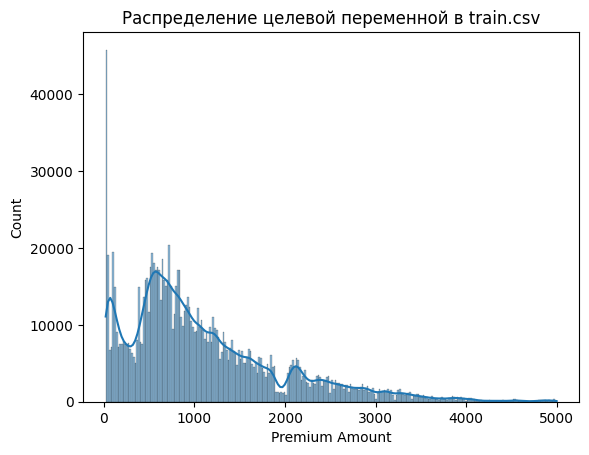

In [82]:
sns.histplot(train_df['Premium Amount'], kde=True)
plt.title("Распределение целевой переменной в train.csv")
plt.show()

Можно заметить несколько скачков в графике. Посмотрим на распределение данных во всей таблице

In [83]:
# посчитаем квантили распределения
train_df['Premium Amount'].describe(percentiles=[0.1, 0.25, 0.75, 0.95 ])

count   1,200,000.00
mean        1,102.55
std           865.00
min            20.00
10%           150.00
25%           514.00
50%           872.00
75%         1,509.00
95%         2,869.00
max         4,999.00
Name: Premium Amount, dtype: float64

In [84]:
train_df.describe(include='all')

,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount,Gender_ordinal_label,Marital Status_ordinal_label,Education Level_ordinal_label,Occupation_ordinal_label,Location_ordinal_label,Policy Type_ordinal_label,Customer Feedback_ordinal_label,Smoking Status_ordinal_label,Exercise Frequency_ordinal_label,Property Type_ordinal_label,Policy Start Year_ordinal_label
count,"1,200,000.00","1,200,000.00","1,200,000.00","1,200,000.00","1,200,000.00","1,200,000.00","1,200,000.00","1,200,000.00","1,200,000.00","1,200,000.00","1,200,000.00","1,200,000.00","1,200,000.00","1,200,000.00","1,200,000.00","1,200,000.00","1,200,000.00","1,200,000.00","1,200,000.00","1,200,000.00"
mean,41.33,"31,783.60",2.10,25.26,0.70,9.57,574.66,5.02,"1,102.55",0.50,1.02,1.48,0.70,1.00,1.00,1.07,0.50,1.49,1.00,2.04
std,13.51,"31,945.18",1.38,11.90,0.94,5.78,149.93,2.59,865.00,0.50,0.82,1.11,0.82,0.82,0.82,0.83,0.50,1.12,0.82,1.53
min,18.00,1.00,0.00,2.01,0.00,0.00,300.00,1.00,20.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,30.00,"7,073.00",1.00,16.55,0.00,5.00,434.00,3.00,514.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
50%,42.00,"22,083.00",2.00,23.29,0.00,10.00,566.00,5.00,872.00,1.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,2.00
75%,53.00,"43,936.00",3.00,33.77,1.00,15.00,706.00,7.00,"1,509.00",1.00,2.00,2.00,1.00,2.00,2.00,2.00,1.00,2.00,2.00,3.00
max,64.00,"149,997.00",4.00,58.98,9.00,19.00,849.00,9.00,"4,999.00",1.00,2.00,3.00,2.00,2.00,2.00,2.00,1.00,3.00,2.00,5.00


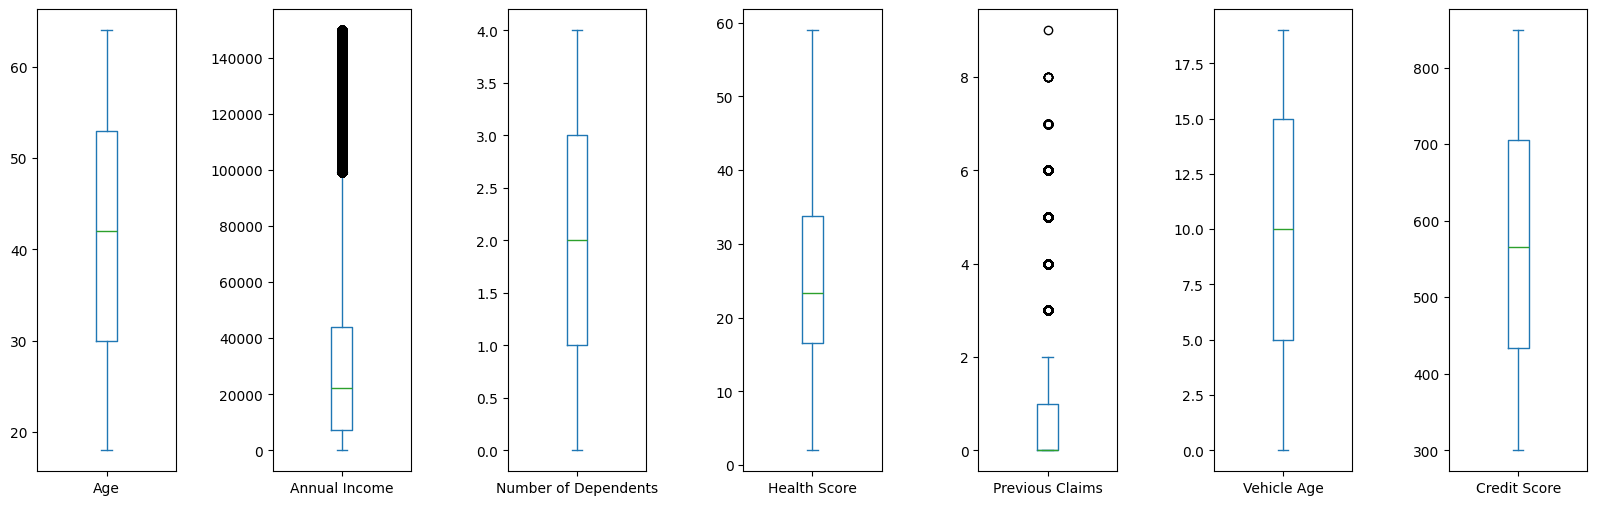

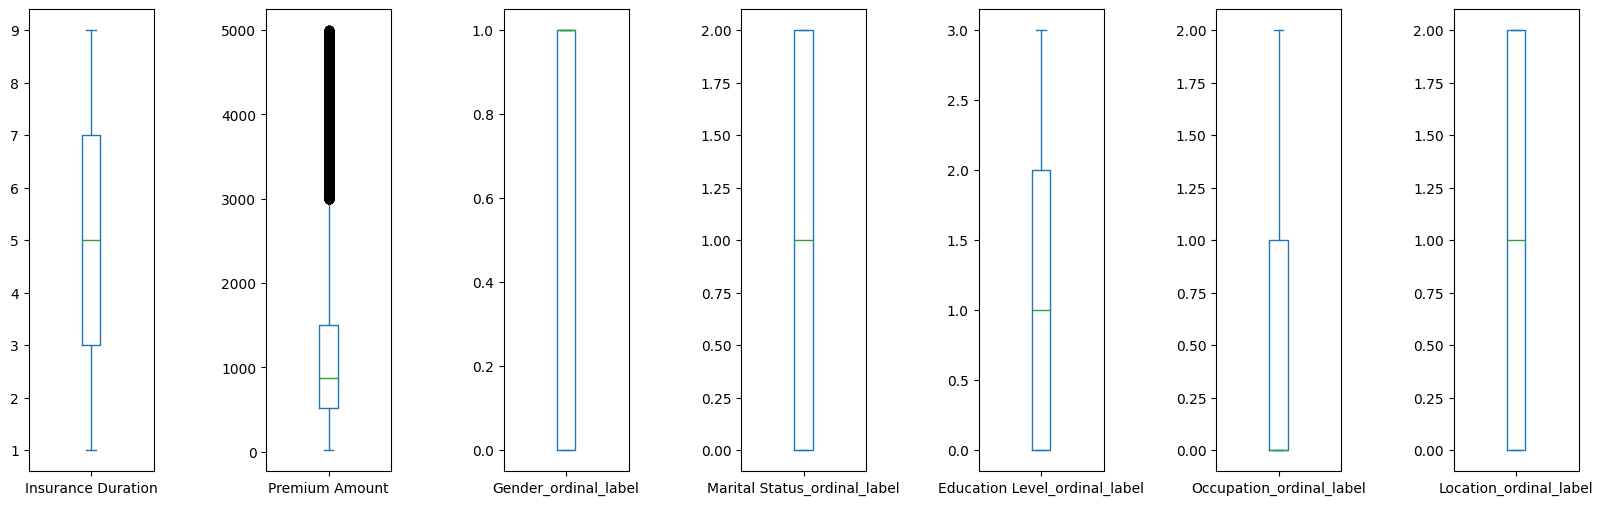

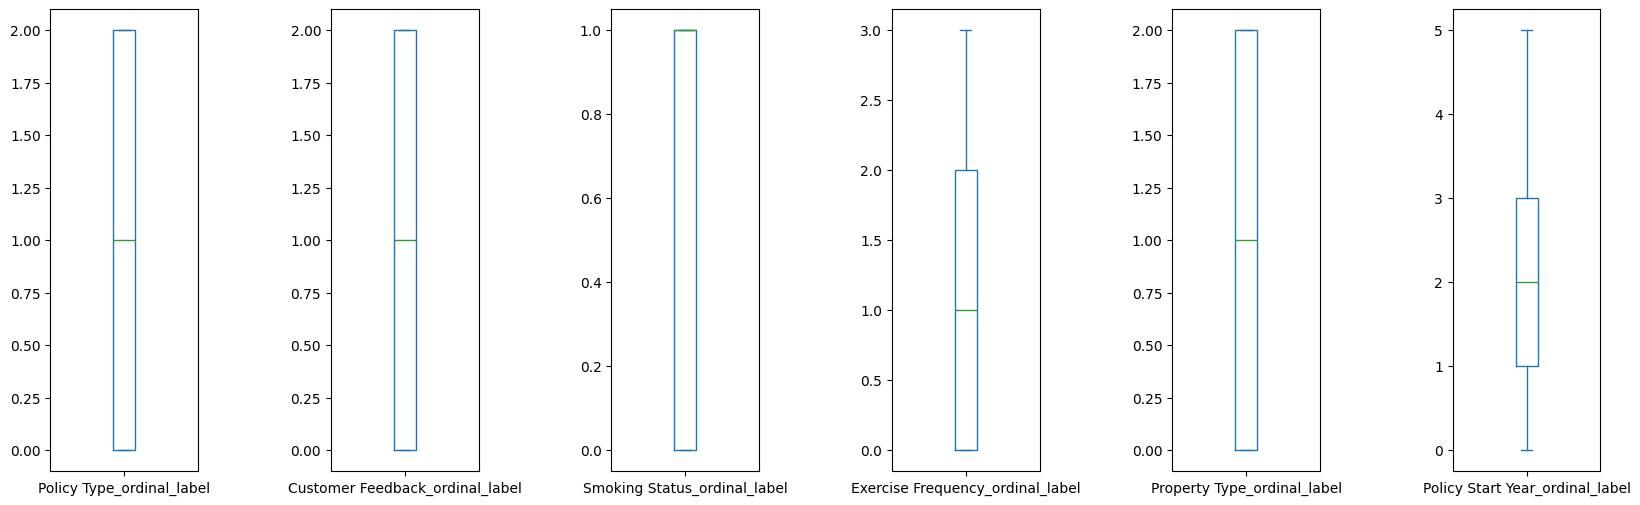

In [85]:
train_df.iloc[:,:7].plot(
    kind='box',
    subplots=True,
    sharey=False,
    figsize= (20,6)
)
plt.subplots_adjust(wspace=0.7)
train_df.iloc[:,7:14].plot(
    kind='box',
    subplots=True,
    sharey=False,
    figsize= (20,6)
)
plt.subplots_adjust(wspace=0.9)
train_df.iloc[:,14:].plot(
    kind='box',
    subplots=True,
    sharey=False,
    figsize= (20,6)
)
plt.subplots_adjust(wspace=0.9)
plt.show()

В столбцах 'Annual Income', 'Previous Claims', 'Premium Amount' можно заметить выбросы. Избавимся от них

In [86]:
def RemoveOutliers(df, column):
    # убираем выбросы
    Q3 = np.quantile(df[column], 0.75, axis=0)
    Q1 = np.quantile(df[column], 0.25, axis=0)
    IQR = Q3 - Q1
    upper = Q3 + 1.5 * IQR
    lower = Q1 - 1.5 * IQR
    df[column] = np.where((df[column] > upper), upper, df[column])
    df[column] = np.where((df[column] < lower), lower, df[column])
    return df

In [87]:
for col in ['Annual Income', 'Previous Claims', 'Premium Amount']:
    train_df = RemoveOutliers(train_df, col)

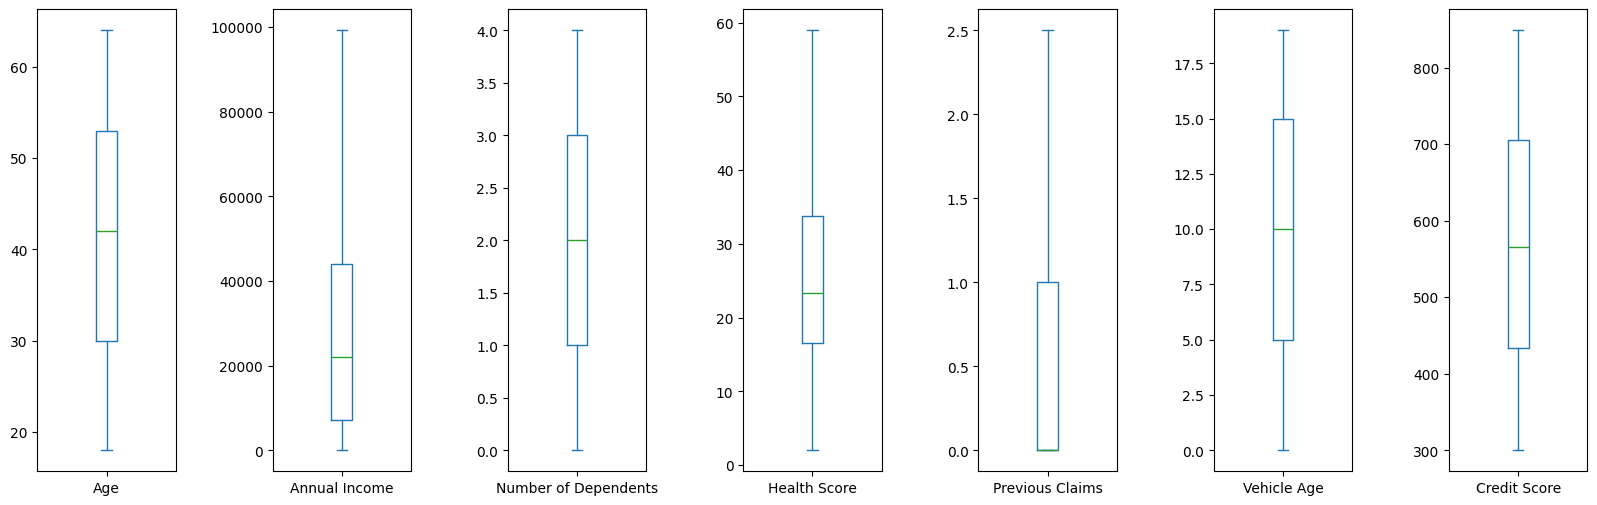

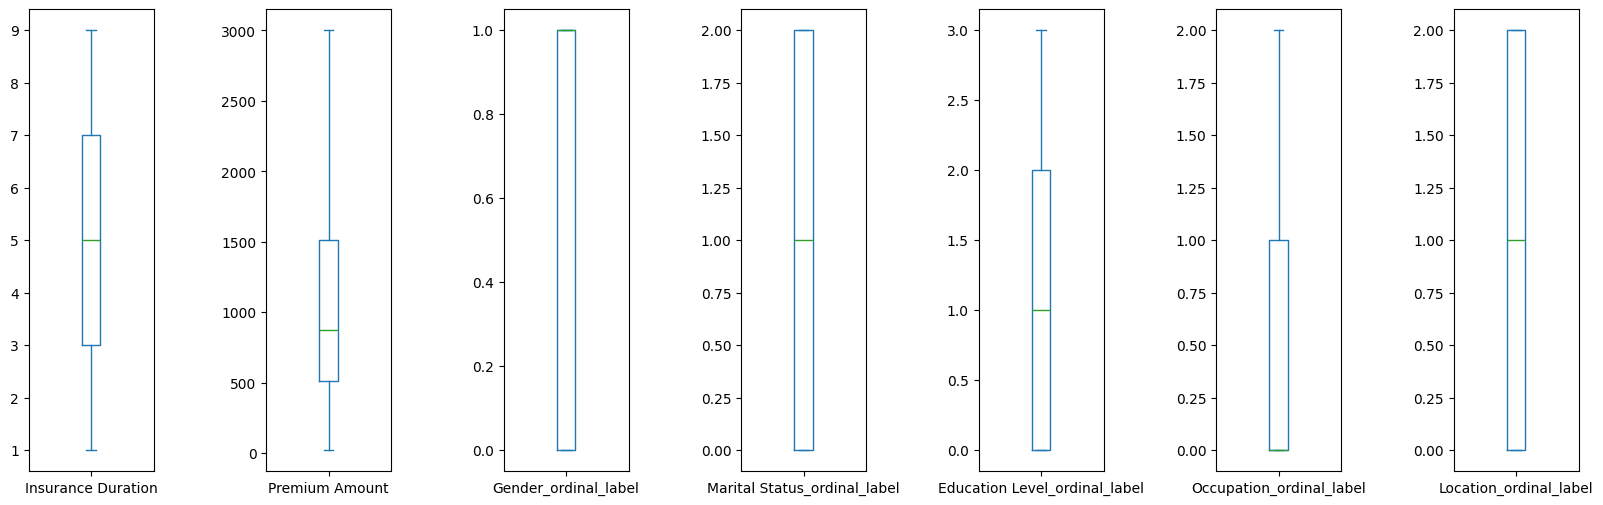

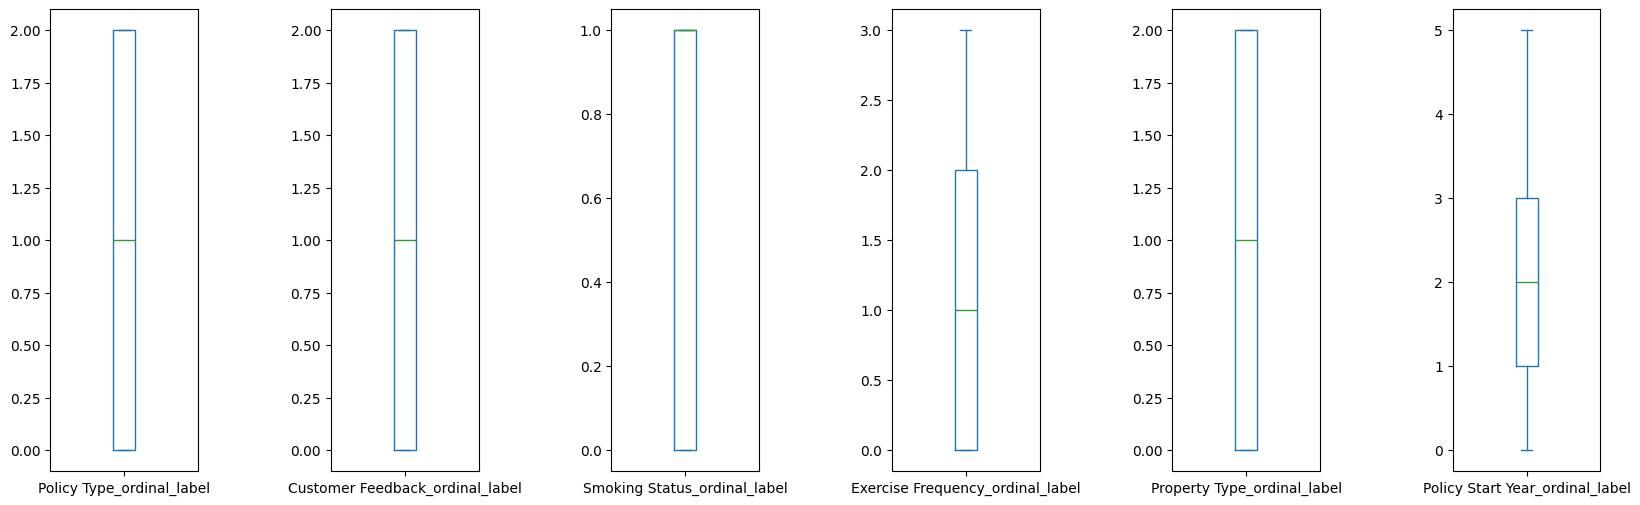

In [88]:
train_df.iloc[:,:7].plot(
    kind='box',
    subplots=True,
    sharey=False,
    figsize= (20,6)
)
plt.subplots_adjust(wspace=0.7)
train_df.iloc[:,7:14].plot(
    kind='box',
    subplots=True,
    sharey=False,
    figsize= (20,6)
)
plt.subplots_adjust(wspace=0.9)
train_df.iloc[:,14:].plot(
    kind='box',
    subplots=True,
    sharey=False,
    figsize= (20,6)
)
plt.subplots_adjust(wspace=0.9)
plt.show()

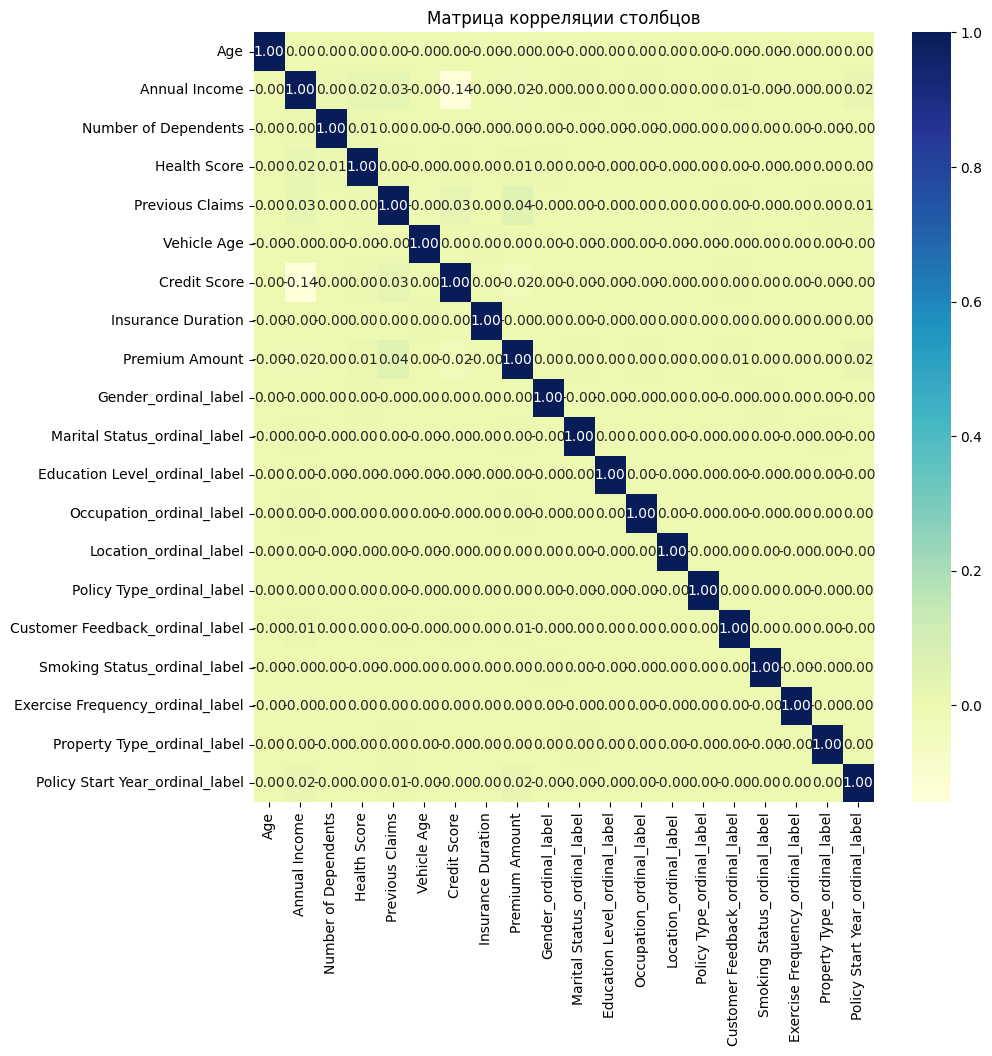

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,10))
sns.heatmap(train_df.corr(), cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Матрица корреляции столбцов")
plt.show()

Между столбцами нет сильной корреляции. Нет необходимости какой-либо из них удалять.

# Обучение моделей

In [6]:
X = train_df.drop('Premium Amount', axis=1)
Y = train_df['Premium Amount']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.3, random_state = 42)

In [8]:
from sklearn.preprocessing import StandardScaler

Scaler = StandardScaler()

X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

In [9]:
regression_error = {}

# RIDGE регрессия

In [10]:
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)
Y_pred_test = ridge_model.predict(X_test)
regression_error['Ridge'] = {"R^2": r2_score(y_test, Y_pred_test),"RMSE":root_mean_squared_error(y_test, Y_pred_test),"MSE":mean_squared_error(y_test, Y_pred_test), "MAE": mean_absolute_error(y_test, Y_pred_test)}

In [11]:
regression_error['Ridge']

{'R^2': 0.0034550836872845325,
 'RMSE': 798.050514745545,
 'MSE': 636884.6240856294,
 'MAE': 639.2957135769572}

# LASSO регрессия

In [12]:
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)
Y_pred_test = lasso_model.predict(X_test)
regression_error['Lasso'] = {"R^2": r2_score(y_test, Y_pred_test),"RMSE":root_mean_squared_error(y_test, Y_pred_test),"MSE":mean_squared_error(y_test, Y_pred_test), "MAE": mean_absolute_error(y_test, Y_pred_test)}

In [13]:
regression_error['Lasso']

{'R^2': 0.0034755463892041094,
 'RMSE': 798.0423212595497,
 'MSE': 636871.5465213304,
 'MAE': 639.3171015009134}

# ElasticNet

In [14]:
elasticNet_model = ElasticNet()
elasticNet_model.fit(X_train, y_train)
Y_pred_test = elasticNet_model.predict(X_test)
regression_error['ElasticNet'] = {"R^2": r2_score(y_test, Y_pred_test),"RMSE":root_mean_squared_error(y_test, Y_pred_test),"MSE":mean_squared_error(y_test, Y_pred_test), "MAE": mean_absolute_error(y_test, Y_pred_test)}

In [15]:
regression_error['ElasticNet']

{'R^2': 0.0030707369554276998,
 'RMSE': 798.2043956861886,
 'MSE': 637130.2572927536,
 'MAE': 639.5645118484472}

In [16]:
pd.options.display.float_format = '{:,.5f}'.format
regression_error_df = pd.DataFrame(regression_error)
regression_error_df

,Ridge,Lasso,ElasticNet
R^2,0.00346,0.00348,0.00307
RMSE,798.05051,798.04232,798.20440
MSE,"636,884.62409","636,871.54652","637,130.25729"
MAE,639.29571,639.31710,639.56451


# GridSearchCV

Лучше всего по метрикам себя показал алгоритм Lasso. Подберем для него лучшие гиперпараметры.

In [17]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'alpha': [0.001, 0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10],
    'max_iter' : [100, 1000, 5000, 10000],
}

elastic_net = GridSearchCV(Lasso(), param_grid, cv=5)

In [18]:
elastic_net.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10],
                         'max_iter': [100, 1000, 5000, 10000]})

In [22]:
print( "Лучшие гиперпараметры для Lasso: ", elastic_net.best_params_)

Лучшие гиперпараметры для Lasso:  {'alpha': 1, 'max_iter': 100}


Посмотрим как изменится качество модели с этими параметрами.

In [20]:
lasso_model = Lasso(alpha=1, max_iter=100)
lasso_model.fit(X_train, y_train)
Y_pred_test = lasso_model.predict(X_test)
regression_error['Lasso with best params'] = {"R^2": r2_score(y_test, Y_pred_test),"RMSE":root_mean_squared_error(y_test, Y_pred_test),"MSE":mean_squared_error(y_test, Y_pred_test), "MAE": mean_absolute_error(y_test, Y_pred_test)}

In [21]:
regression_error_df = pd.DataFrame(regression_error)
regression_error_df

,Ridge,Lasso,ElasticNet,Lasso with best params
R^2,0.00346,0.00348,0.00307,0.00348
RMSE,798.05051,798.04232,798.20440,798.04232
MSE,"636,884.62409","636,871.54652","637,130.25729","636,871.54652"
MAE,639.29571,639.31710,639.56451,639.31710


Можно увидеть, что качество алгоритма Lasso с лучшими гиперпараметрами не изменилось по сравнению с базовым.